In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import warnings
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# 忽略特定的警告
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)  # 用 UserWarning 替代 ValueWarning
# 创建一个随机过采样器实例
ros = RandomOverSampler(random_state=0)

# 从新的CSV文件载入处理后的数据
processed_file_path = '/Users/sdong/phd_doc/dataset/processed_human_activities.csv'
windowed_data = pd.read_csv(processed_file_path)

# 提取用户1的数据
user1_data = windowed_data[windowed_data['user'] <= 3]
X_user1 = user1_data[['x_mean', 'y_mean', 'z_mean']]
y_user1 = user1_data['activity']

# 将用户1的数据分为训练集和验证集
X_train_user1, X_test_user1, y_train_user1, y_test_user1 = train_test_split(X_user1, y_user1, test_size=0.5, random_state=0)

# 训练随机森林模型
model_rf_baseline6 = RandomForestClassifier(n_estimators=10,max_depth=4, random_state=0)
# 使用过采样器平衡训练数据集
X_train_user1_balanced, y_train_user1_balanced = ros.fit_resample(X_train_user1, y_train_user1)
model_rf_baseline6.fit(X_train_user1_balanced, y_train_user1_balanced)

# 准备其他用户的数据
other_users_data = windowed_data[windowed_data['user'] > 3]
X_other_users = other_users_data[['x_mean', 'y_mean', 'z_mean']]
y_other_users = other_users_data['activity']


# 在验证集上评估模型
y_pred_user1 = model_rf_baseline6.predict(X_test_user1)
accuracy = accuracy_score(y_test_user1, y_pred_user1)
print(f'Accuracy on User 1 validation set: {accuracy}')

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# 重新标记预测结果：预测错误的数据标记为1，预测正确的数据标记为0
y_new_labels = (y_pred_user1 != y_test_user1).astype(int)

# 计算标签为0和1的比例
proportion_label_0 = (y_new_labels == 0).mean()
proportion_label_1 = (y_new_labels == 1).mean()

# 打印比例
print(f"Proportion of label 0: {proportion_label_0:.2f}, label 1: {proportion_label_1:.2f}")

# 使用默认参数的决策树
decision_tree_default = DecisionTreeClassifier(random_state=16)
decision_tree_default.fit(X_test_user1, y_new_labels)

y_pred_dt_default = decision_tree_default.predict(X_test_user1)
accuracy_dt_default = accuracy_score(y_new_labels, y_pred_dt_default)

#print(f"Accuracy with GridSearchCV: {accuracy_dt_gs}")
print(f"Accuracy with Default Parameters: {accuracy_dt_default}")


import time  # 引入时间模块

# 初始化计数器和时间累加器
retrain_count = 0
total_retrain_time = 0

accuracies_baseline6 = []
selected_samples_accuracies = []
train_accuracies = []
error_ratios = []
# 定义阈值
GROWTH_THRESHOLD = 0  # 增长的阈值
PROPORTION_THRESHOLD = 0.0  # 比例的阈值

# 准备累积数据用于更新 Baseline 6
cumulative_X_train_baseline6 = X_train_user1.copy()
cumulative_y_train_baseline6 = y_train_user1.copy()



# 函数：提取决策树中预测为1的分支条件
def extract_decision_paths(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i >= 0 else "undefined!"
        for i in tree_.feature
    ]
    paths = []

    def recurse(node, path_conditions):
        if tree_.feature[node] >= 0:  # 非叶子节点
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], path_conditions + [(name, "<=", threshold)])
            recurse(tree_.children_right[node], path_conditions + [(name, ">", threshold)])
        else:
            if tree_.value[node][0][1] > tree_.value[node][0][0]:  # 预测为1的节点
                paths.append(path_conditions)

    recurse(0, [])
    return paths

# 提取预测为1的分支条件
decision_paths = extract_decision_paths(decision_tree_default, ['x_mean', 'y_mean', 'z_mean'])


# 计算样本是否符合某个决策路径
def sample_matches_path(sample, path):
    return all(sample[feature] <= threshold if condition == "<=" else sample[feature] > threshold
               for feature, condition, threshold in path)

# 函数：计算符合决策路径的样本比例
def calculate_path_proportions(data, paths):
    proportions = []
    for path in paths:
        matches = data.apply(lambda x: sample_matches_path(x, path), axis=1)
        proportion = np.mean(matches)
        proportions.append(proportion)
    return proportions


# 循环处理每个测试批次
for i in range(0, other_users_data.shape[0], 500):
    batch = other_users_data.iloc[i:i+500]
    X_test = batch[['x_mean', 'y_mean', 'z_mean']]
    y_test = batch['activity']
    
    y_pred_batch = model_rf_baseline6.predict(X_test)
    accuracy_batch = accuracy_score(y_test, y_pred_batch)
    print(f"Batch {i//500} Accuracy berfore retrain: {accuracy_batch:.2f}")
    
    # 计算当前训练集和测试批次的分布比例
    train_proportions = calculate_path_proportions(cumulative_X_train_baseline6, decision_paths)
    batch_proportions = calculate_path_proportions(X_test, decision_paths)

    # # 计算并打印每个批次在特定分支的样本数及占比
    # for path_index, path in enumerate(decision_paths):
    #     batch_matches = X_test.apply(lambda x: sample_matches_path(x, path), axis=1)
    #     num_matches = batch_matches.sum()
    #     proportion_matches = batch_proportions[path_index]
    #     print(f"Batch {i//500}: Path {path_index}, Matches: {num_matches}, Proportion: {proportion_matches:.2f}")
        
    # 计算当前训练集和测试批次的总体分布比例
    train_matches = cumulative_X_train_baseline6.apply(lambda x: any(sample_matches_path(x, path) for path in decision_paths), axis=1)
    batch_matches = X_test.apply(lambda x: any(sample_matches_path(x, path) for path in decision_paths), axis=1)
    
    train_proportion = train_matches.mean()
    batch_proportion = batch_matches.mean()

    # 打印每个批次的匹配信息
    #print(f"Batch {i//500}: Total Matches: {batch_matches.sum()}, Batch Proportion: {batch_proportion:.2f}, Train Proportion: {train_proportion:.2f}")
    
    # 计算增长和比例
    growth = [batch_prop - train_prop for batch_prop, train_prop in zip(batch_proportions, train_proportions)]
    exceed_growth_threshold = any(g > GROWTH_THRESHOLD for g in growth)
    exceed_proportion_threshold = any(batch_prop > PROPORTION_THRESHOLD for batch_prop in batch_proportions)



    # 如果测试批次在任何分布上的占比增加，则重新训练模型
    if exceed_growth_threshold and exceed_proportion_threshold:
        # 初始化选中样本的DataFrame和标签Series
        selected_samples = pd.DataFrame(columns=X_test.columns)
        selected_labels = pd.Series()

        # 遍历每个决策路径，收集符合条件的样本
        for path in decision_paths:
            matches = X_test.apply(lambda x: sample_matches_path(x, path), axis=1)
            selected_samples = selected_samples.append(X_test[matches])
            selected_labels = selected_labels.append(y_test[matches])
            
        selected_samples= selected_samples.sort_index()
        selected_labels= selected_labels.sort_index()
        if i == 0:
            print(selected_samples)
            print(selected_labels)
        # 如果有被选择的样本，计算并打印这些样本的准确率
        if selected_samples.shape[0] > 0:
            y_pred_selected = model_rf_baseline6.predict(selected_samples)
            accuracy_selected = accuracy_score(selected_labels, y_pred_selected)
            print(f"Batch {i//500}: selected samples size: {selected_samples.shape[0]}, Accuracy: {accuracy_selected:.2f}")

        # 将选中的样本加入累积训练集
        cumulative_X_train_baseline6 = pd.concat([cumulative_X_train_baseline6, selected_samples])
        cumulative_y_train_baseline6 = pd.concat([cumulative_y_train_baseline6, selected_labels])


        # 使用过采样器平衡训练数据集
        X_train_user1_balanced, y_train_user1_balanced = ros.fit_resample(cumulative_X_train_baseline6, cumulative_y_train_baseline6)
    
        # 开始计时
        start_time = time.time()
    
        # 重新训练随机森林模型
        model_rf_baseline6.fit(X_train_user1_balanced, y_train_user1_balanced)
        
        # 结束计时并更新统计数据
        end_time = time.time()
        retrain_time = end_time - start_time
        total_retrain_time += retrain_time
        retrain_count += 1
        
        # 重新标记训练数据用来训练新的决策树
        y_pred_train = model_rf_baseline6.predict(cumulative_X_train_baseline6)
        y_new_labels = (y_pred_train != cumulative_y_train_baseline6).astype(int)
        
        
        # 计算标签为0和1的比例
        proportion_label_0 = (y_new_labels == 0).mean()
        proportion_label_1 = (y_new_labels == 1).mean()

        # 打印比例
        print(f"Proportion of label 0: {proportion_label_0:.2f}, label 1: {proportion_label_1:.2f}")
      
        print(len(cumulative_X_train_baseline6))
        
        decision_tree_default.fit(cumulative_X_train_baseline6, y_new_labels)
        
        # 提取预测为1的分支条件
        decision_paths = extract_decision_paths(decision_tree_default, ['x_mean', 'y_mean', 'z_mean'])

        y_pred_dt_default = decision_tree_default.predict(cumulative_X_train_baseline6)
        accuracy_dt_default = accuracy_score(cumulative_y_train_baseline6, y_pred_dt_default)

        #print(f"Accuracy with GridSearchCV: {accuracy_dt_gs}")
        print(f"Accuracy with Default Parameters: {accuracy_dt_default}")
        
        
        # 计算并记录训练数据的准确率
        train_accuracy = accuracy_score(cumulative_y_train_baseline6, y_pred_train)
        train_accuracies.append(train_accuracy)
        
        print(f"Batch {i//500} Accuracy berfore retrain: {accuracy_batch:.2f}, after retrain: {train_accuracy:.2f}")
    else:
        print(f"Batch {i//500}: No retraining required.")

    # 计算和记录当前批次的准确率
    y_pred_baseline = model_rf_baseline6.predict(X_test)
    current_accuracy = accuracy_score(y_test, y_pred_baseline)
    accuracies_baseline6.append(current_accuracy)

    
# 打印重训的总次数和总时间
print(f"Total retrainings: {retrain_count}")
print(f"Total retraining time: {total_retrain_time:.2f} seconds")

# 绘制准确率折线图
plt.figure(figsize=(12, 8))
plt.plot(accuracies_baseline6, marker='o', label='Baseline with Dynamic Training')
plt.title('Model Accuracy over Test Batches with Dynamic Training')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Accuracy on User 1 validation set: 0.7677935943060499
Proportion of label 0: 0.77, label 1: 0.23
Accuracy with Default Parameters: 1.0
Batch 0 Accuracy berfore retrain: 0.31
        x_mean     y_mean    z_mean
2249  1.718500   9.309750  0.462750
2308  2.755750  10.949250 -0.961000
2399  0.135000   6.010000  0.380000
2400  5.701176   5.753235 -2.068529
2401  4.829512   7.939268 -2.910244
...        ...        ...       ...
2742  3.607750   9.081000  1.445459
2743  3.546500   9.215000  1.681091
2744  3.682000   8.996000  1.604817
2745  3.761026   8.956667  1.540496
2746  3.711951   8.975366  1.546076

[178 rows x 3 columns]
2249    5
2308    5
2399    5
2400    1
2401    1
       ..
2742    5
2743    5
2744    5
2745    5
2746    5
Length: 178, dtype: int64
Batch 0: selected samples size: 178, Accuracy: 0.01
Proportion of label 0: 0.83, label 1: 0.17
1301
Accuracy with Default Parameters: 0.09684857801691008
Batch 0 Accuracy berfore retrain: 0.31, after retrain: 0.83
Batch 1 Accuracy ber


KeyboardInterrupt



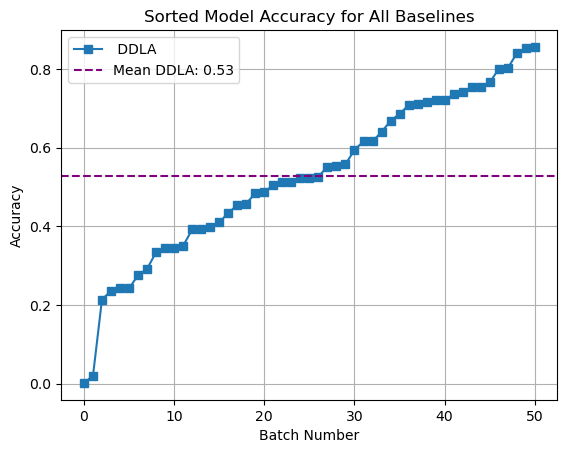

In [10]:
import matplotlib.pyplot as plt


sorted_accuracies_baseline6 = sorted(accuracies_baseline6)

# 计算每个列表的均值
mean_accuracy_baseline6 = sum(sorted_accuracies_baseline6) / len(sorted_accuracies_baseline6)

plt.plot(sorted_accuracies_baseline6, marker='s', label=' DDLA')

plt.axhline(y=mean_accuracy_baseline6, color='purple', linestyle='--', label=f'Mean DDLA: {mean_accuracy_baseline6:.2f}')

plt.title('Sorted Model Accuracy for All Baselines')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Accuracy of Random Forest on User 1 validation set: 0.7677935943060499
Accuracy with Default Parameters: 1.0
Accuracy with Heuristic Parameters: 0.9119217081850534
Accuracy with Best Parameters from GridSearchCV: 0.9332740213523132


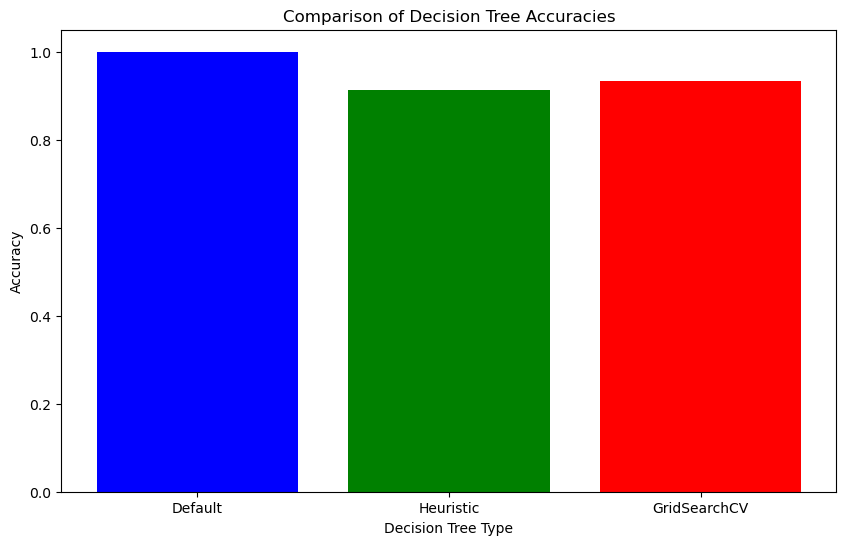

Depth of Default Decision Tree: 15
Depth of Heuristic Decision Tree: 9
Depth of Best Decision Tree from GridSearchCV: 10


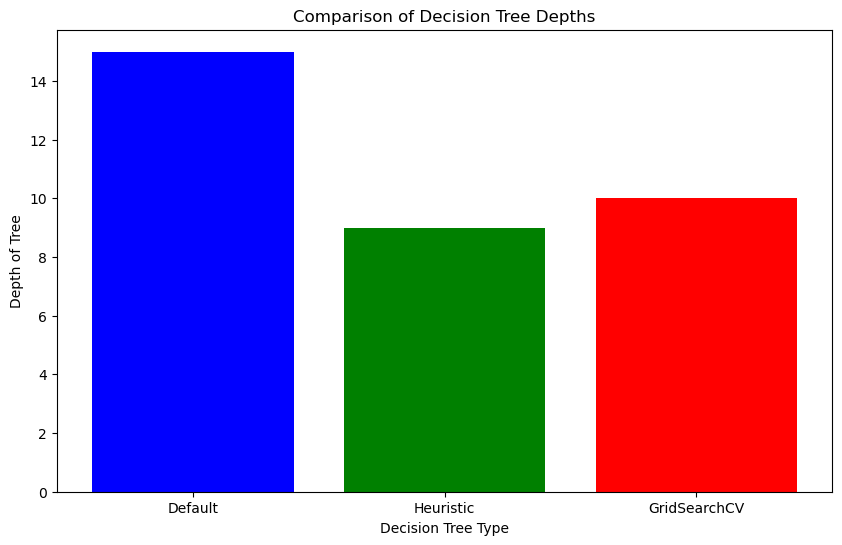

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler

# 从CSV文件载入数据
processed_file_path = '/Users/sdong/phd_doc/dataset/processed_human_activities.csv'
windowed_data = pd.read_csv(processed_file_path)

# 提取用户1的数据
user1_data = windowed_data[windowed_data['user'] <= 3]
X_user1 = user1_data[['x_mean', 'y_mean', 'z_mean']]
y_user1 = user1_data['activity']

# 将用户1的数据分为训练集和验证集
X_train_user1, X_test_user1, y_train_user1, y_test_user1 = train_test_split(X_user1, y_user1, test_size=0.5, random_state=0)

# 训练随机森林模型
model_rf = RandomForestClassifier(n_estimators=10, max_depth=4, random_state=0)
ros = RandomOverSampler(random_state=0)
X_train_user1_balanced, y_train_user1_balanced = ros.fit_resample(X_train_user1, y_train_user1)
model_rf.fit(X_train_user1_balanced, y_train_user1_balanced)

# 在验证集上评估随机森林模型
y_pred_rf = model_rf.predict(X_test_user1)
accuracy_rf = accuracy_score(y_test_user1, y_pred_rf)
print(f'Accuracy of Random Forest on User 1 validation set: {accuracy_rf}')

# 重新标记预测结果
y_new_labels = (y_pred_rf != y_test_user1).astype(int)

# 使用默认参数的决策树
decision_tree_default = DecisionTreeClassifier(random_state=0)
decision_tree_default.fit(X_test_user1, y_new_labels)
accuracy_dt_default = accuracy_score(y_new_labels, decision_tree_default.predict(X_test_user1))

# 启发式参数设置
max_depth = int(np.log2(X_train_user1.shape[1]) + 10)
min_samples_split = max(2, int(X_train_user1.shape[0] * 0.01))
min_samples_leaf = max(1, int(X_train_user1.shape[0] * 0.01))
decision_tree_choose = DecisionTreeClassifier(
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=0
)
decision_tree_choose.fit(X_test_user1, y_new_labels)
accuracy_dt_choose = accuracy_score(y_new_labels, decision_tree_choose.predict(X_test_user1))

# 网格搜索参数设置
parameters = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [8, 10, 15, 20],
    'criterion': ['gini', 'entropy']
}
decision_tree = DecisionTreeClassifier(random_state=0)
clf = GridSearchCV(decision_tree, parameters, cv=5)
clf.fit(X_test_user1, y_new_labels)
best_tree = clf.best_estimator_
accuracy_dt_best = accuracy_score(y_new_labels, best_tree.predict(X_test_user1))

# 显示结果
print(f"Accuracy with Default Parameters: {accuracy_dt_default}")
print(f"Accuracy with Heuristic Parameters: {accuracy_dt_choose}")
print(f"Accuracy with Best Parameters from GridSearchCV: {accuracy_dt_best}")

# 可视化比较
plt.figure(figsize=(10, 6))
accuracies = [accuracy_dt_default, accuracy_dt_choose, accuracy_dt_best]
labels = ['Default', 'Heuristic', 'GridSearchCV']
plt.bar(labels, accuracies, color=['blue', 'green', 'red'])
plt.xlabel('Decision Tree Type')
plt.ylabel('Accuracy')
plt.title('Comparison of Decision Tree Accuracies')
plt.show()

# ...之前的代码...

# 获取每个决策树的深度
depth_default = decision_tree_default.get_depth()
depth_choose = decision_tree_choose.get_depth()
depth_best = best_tree.get_depth()

# 打印每个决策树的深度
print(f"Depth of Default Decision Tree: {depth_default}")
print(f"Depth of Heuristic Decision Tree: {depth_choose}")
print(f"Depth of Best Decision Tree from GridSearchCV: {depth_best}")

# 可视化比较
plt.figure(figsize=(10, 6))
depths = [depth_default, depth_choose, depth_best]
labels = ['Default', 'Heuristic', 'GridSearchCV']
plt.bar(labels, depths, color=['blue', 'green', 'red'])
plt.xlabel('Decision Tree Type')
plt.ylabel('Depth of Tree')
plt.title('Comparison of Decision Tree Depths')
plt.show()


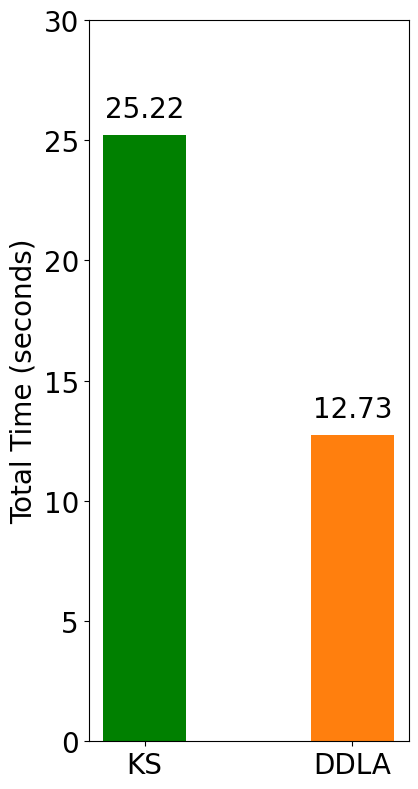

In [37]:
import matplotlib.pyplot as plt

# 定义数据
methods = ['KS', 'DDLA']
retrain_times = [25.22, 12.73]

# 创建图表
plt.figure(figsize=(4.286, 8))

# 画柱状图，调整柱子宽度并设置颜色
bar_width = 0.4
plt.bar(methods, retrain_times, width=bar_width, color=['green', '#ff7f0e'])

# 在柱子上方添加数据标签
for index, value in enumerate(retrain_times):
    plt.text(index, value + 0.5, f'{value:.2f}', ha='center', va='bottom', fontsize=20)

# 添加标题和标签
#plt.title('Total Retraining Time Comparison', fontsize=20)
plt.ylabel('Total Time (seconds)', fontsize=20)

# 设置坐标轴标签大小
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# 设置y轴的范围
plt.ylim(0, 30)

# 显示图表
plt.tight_layout()  # 调整布局以适应标签

# 保存为PDF文件
pdf_file_path = '/Users/sdong/phd_doc/att/Fraud/Figures/model_time_baselines.pdf'
plt.savefig(pdf_file_path, format='pdf', bbox_inches='tight')

plt.show()
